In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from flash_ansr import get_path, FlashANSRTransformer

In [2]:
MODEL = 'v6.0'
CHECKPOINT = ''

In [5]:
trf = FlashANSRTransformer.load(get_path('models', 'ansr-models', MODEL, CHECKPOINT))[1].eval()

In [39]:
trf.encoder.enc[0].mab0

MAB(
  (W_q): Linear(in_features=512, out_features=512, bias=True)
  (W_k): Linear(in_features=64, out_features=512, bias=True)
  (W_v): Linear(in_features=64, out_features=512, bias=True)
  (fc_o): Linear(in_features=512, out_features=512, bias=True)
)

In [59]:
induction_points = trf.encoder.enc[0].inducing_points.detach()[0]
induction_points.shape  # (n_induction_points, hidden_dim)

torch.Size([64, 512])

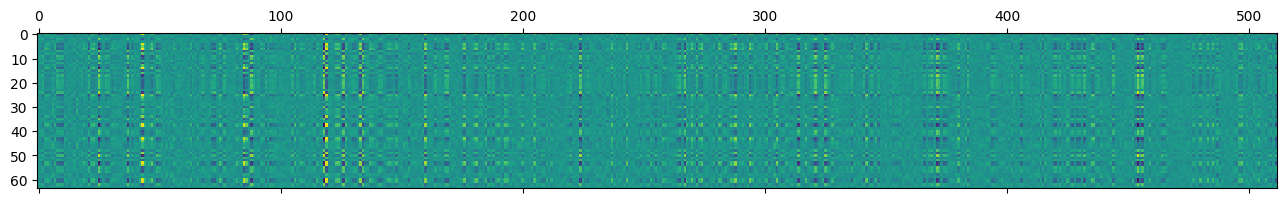

In [21]:
plt.matshow(induction_points)

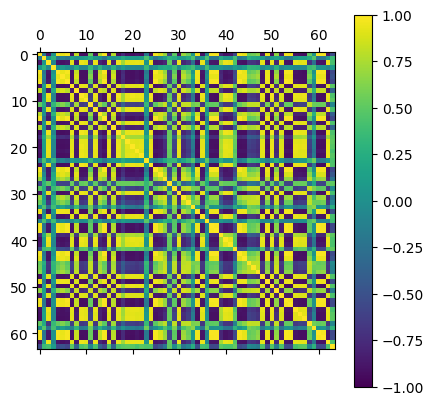

In [26]:
# Compute the pairwise cosine similarities between the inducing points
cosine_similarities = np.zeros((induction_points.shape[0], induction_points.shape[0]))
for i in range(induction_points.shape[0]):
    for j in range(induction_points.shape[0]):
        cosine_similarities[i, j] = torch.nn.functional.cosine_similarity(induction_points[i], induction_points[j], dim=0).item()

plt.matshow(cosine_similarities, vmin=-1, vmax=1)
plt.colorbar()

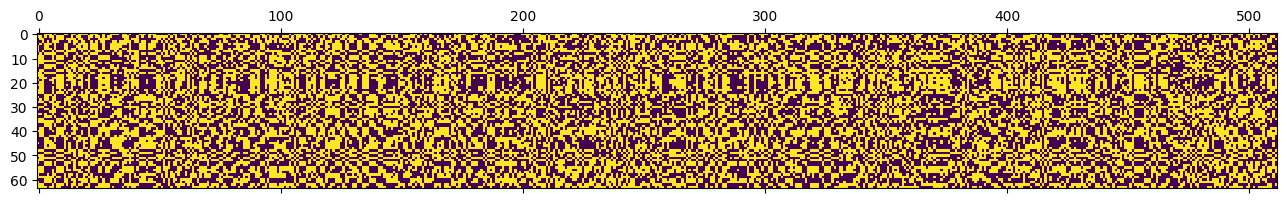

In [29]:
quantized_induction_points = torch.copysign(torch.ones_like(induction_points), induction_points)
plt.matshow(quantized_induction_points)

In [124]:
W = trf.encoder.enc[0].mab0.W_k.weight.data
W.shape  # (hidden_dim, input_dim)

torch.Size([512, 64])

In [125]:
# Multiply the pseudo-inverse of W with the induction points to get the corresponding input points
input_points = torch.matmul(torch.pinverse(W), induction_points.T)
input_points.shape  # (input_dim, n_induction_points)

torch.Size([64, 64])

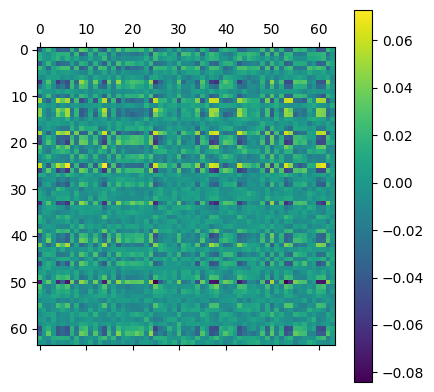

In [126]:
plt.matshow(input_points)
plt.colorbar()

In [127]:
quantized_input_points = torch.copysign(torch.ones_like(input_points), input_points)
quantized_input_points[quantized_input_points == -1] = 0
quantized_input_points = quantized_input_points.T.reshape(64, 4, 16)

In [128]:
import numpy as np
import torch

def binary_to_float16(binary_input):
    """
    Convert binary (0/1) sequences to IEEE-754 half-precision floating point numbers.

    Args:
        binary_input: numpy array of shape (..., 16) containing 0s and 1s

    Returns:
        Same type as input (numpy array or torch tensor) with shape (...) containing float values
    """
    # Ensure input is correct shape and type
    assert binary_input.shape[-1] == 16, "Last dimension must be 16"
    assert np.all(np.isin(binary_input, [0, 1])), "Input must contain only 0s and 1s"

    # Extract components
    sign = binary_input[..., 0:1]
    exponent = binary_input[..., 1:6]
    fraction = binary_input[..., 6:16]

    # Convert sign
    sign_float = (-1) ** sign

    # Convert exponent (binary to decimal)
    exp_weights = 2.0 ** np.arange(4, -1, -1)
    exponent_val = np.sum(exponent * exp_weights, axis=-1)

    # Convert fraction (binary to decimal)
    frac_weights = 2.0 ** np.arange(-1, -11, -1)
    fraction_val = np.sum(fraction * frac_weights, axis=-1)

    # Handle special cases
    result = np.zeros_like(exponent_val, dtype=np.float32)

    # Normal numbers
    normal_mask = (exponent_val > 0) & (exponent_val < 31)
    result[normal_mask] = (1 + fraction_val[normal_mask]) * (2 ** (exponent_val[normal_mask] - 15))

    # Denormal numbers
    denormal_mask = exponent_val == 0
    result[denormal_mask] = fraction_val[denormal_mask] * (2 ** -14)

    # Infinity and NaN
    inf_mask = (exponent_val == 31) & (fraction_val == 0)
    nan_mask = (exponent_val == 31) & (fraction_val != 0)
    result[inf_mask] = np.inf
    result[nan_mask] = np.nan

    # Apply sign
    return sign_float.reshape(sign_float.shape[:-1]) * result


In [129]:
induction_point_values = binary_to_float16(quantized_input_points.numpy())

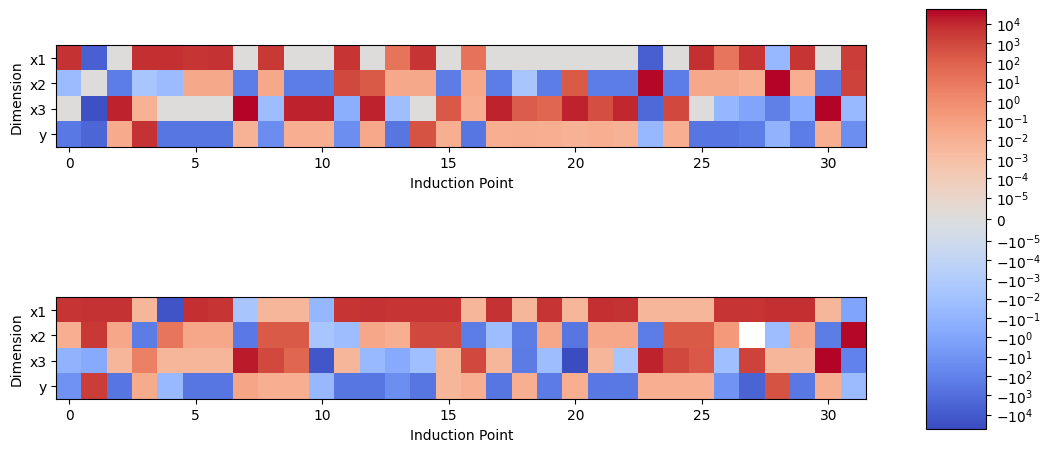

In [130]:
from matplotlib.colors import SymLogNorm

vmax = np.nanmax(np.abs(induction_point_values))

# Show the values of the input points. Use a logarithmic color scale to better visualize the range of values. Use red for positive values and blue for negative values.
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].imshow(induction_point_values.T[:, :32], cmap='coolwarm', norm=SymLogNorm(1e-5, vmin=-vmax, vmax=vmax))
axes[1].imshow(induction_point_values.T[:, 32:], cmap='coolwarm', norm=SymLogNorm(1e-5, vmin=-vmax, vmax=vmax))

for ax in axes:
    ax.set_xlabel('Induction Point')
    ax.set_ylabel('Dimension')
    ax.set_yticks(range(4))
    ax.set_yticklabels(['x1', 'x2', 'x3', 'y'])

# Add colorbar on the right side, spanning both subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plt.cm.ScalarMappable(cmap='coolwarm', norm=SymLogNorm(1e-5, vmin=-vmax, vmax=vmax)), cax=cbar_ax)